<h1 align=center><font size = 5>Pyramid Vision Transformer </h1 >

<h3>Objective for this Notebook</h3>
<h5> 1. 觀看架構圖，試著撰寫出模型</h5>
<hr>

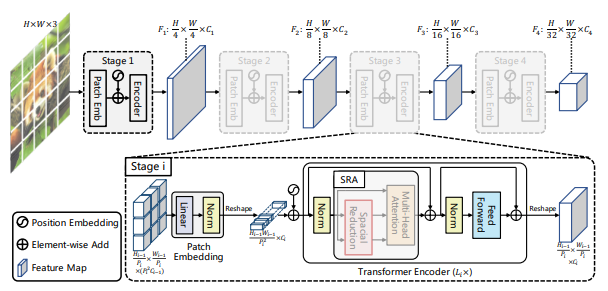

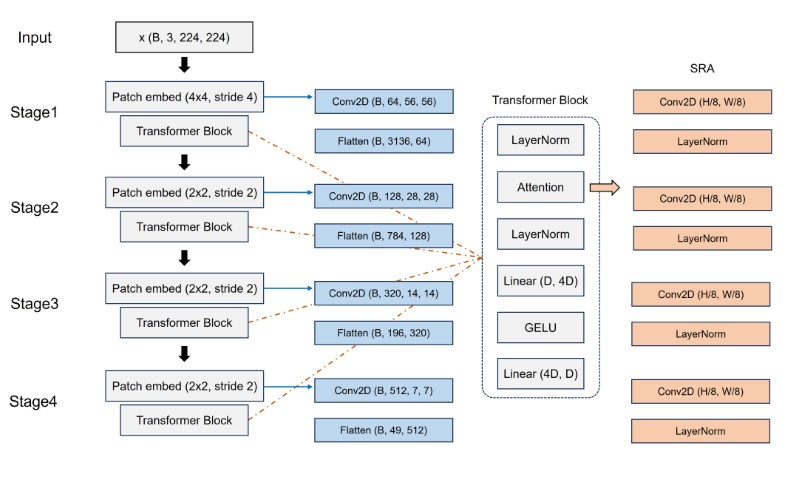

In [1]:
import torch
import torch.nn as nn

In [ ]:
class PatchEmbed(nn.Module):
    def __init__(self, in_chans, embed_dim, patch_size):
        super().__init__()


    def forward(self, x):
        # [B, C, H, W]
        # [B, N, C]



        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads, sr_ratio):
        super().__init__()
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5

        self.q = nn.Linear(dim, dim)
        self.kv = nn.Linear(dim, dim * 2)

        if sr_ratio > 1:

            #sr_ratio

            self.norm = nn.LayerNorm(dim)
        else:
            self.sr = self.norm = None

        self.proj = nn.Linear(dim, dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).transpose(1, 2)

        if self.sr is not None:
            #B, C, H, W
            #sr




        else:
            kv = self.kv(x)

        #kv

        #qk

        #softmax

        #qkv

        return #proj


class Block(nn.Module):
    def __init__(self, dim, num_heads, sr_ratio):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads, sr_ratio)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x, H, W):
        x = x + self.attn(self.norm1(x), H, W)
        x = x + self.mlp(self.norm2(x))
        return x


class PVT(nn.Module):
    def __init__(self):
        super().__init__()
        self.stage1 = nn.Sequential(
            PatchEmbed(3, 64, patch_size=4),
            Block(64, num_heads=1, sr_ratio=8)
        )
        self.stage2 = nn.Sequential(
            PatchEmbed(64, 128, patch_size=2),
            Block(128, num_heads=2, sr_ratio=4)
        )
        self.stage3 = nn.Sequential(
            PatchEmbed(128, 320, patch_size=2),
            Block(320, num_heads=5, sr_ratio=2)
        )
        self.stage4 = nn.Sequential(
            PatchEmbed(320, 512, patch_size=2),
            Block(512, num_heads=8, sr_ratio=1)
        )
        self.head = nn.Linear(512, 1000)

    def forward(self, x):
        for stage in [self.stage1, self.stage2, self.stage3, self.stage4]:
            x = stage[0](x)  # patch embed
            B, N, C = x.shape
            H = W = int(N ** 0.5)  # 假設方形
            x = stage[1](x, H, W)

            print(x.shape)  # after each stage


        cls_token = x.mean(dim=1)
        return self.head(cls_token)


# 雙擊展開正確答案

<!--
class PatchEmbed(nn.Module):
    def __init__(self, in_chans, embed_dim, patch_size):
        super().__init__()
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # [B, C, H, W]
        x = x.flatten(2).transpose(1, 2)  # [B, N, C]
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads, sr_ratio):
        super().__init__()
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5

        self.q = nn.Linear(dim, dim)
        self.kv = nn.Linear(dim, dim * 2)

        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)
        else:
            self.sr = self.norm = None

        self.proj = nn.Linear(dim, dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).transpose(1, 2)

        if self.sr is not None:
            x_ = x.transpose(1, 2).reshape(B, C, H, W)
            x_ = self.sr(x_).flatten(2).transpose(1, 2)
            x_ = self.norm(x_)
            kv = self.kv(x_)
        else:
            kv = self.kv(x)

        kv = kv.reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(out)


class Block(nn.Module):
    def __init__(self, dim, num_heads, sr_ratio):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads, sr_ratio)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, x, H, W):
        x = x + self.attn(self.norm1(x), H, W)
        x = x + self.mlp(self.norm2(x))
        return x


class PVT(nn.Module):
    def __init__(self):
        super().__init__()
        self.stage1 = nn.Sequential(
            PatchEmbed(3, 64, patch_size=4),
            Block(64, num_heads=1, sr_ratio=8)
        )
        self.stage2 = nn.Sequential(
            PatchEmbed(64, 128, patch_size=2),
            Block(128, num_heads=2, sr_ratio=4)
        )
        self.stage3 = nn.Sequential(
            PatchEmbed(128, 320, patch_size=2),
            Block(320, num_heads=5, sr_ratio=2)
        )
        self.stage4 = nn.Sequential(
            PatchEmbed(320, 512, patch_size=2),
            Block(512, num_heads=8, sr_ratio=1)
        )
        self.head = nn.Linear(512, 1000)

    def forward(self, x):
        for stage in [self.stage1, self.stage2, self.stage3, self.stage4]:
            x = stage[0](x)  # patch embed
            B, N, C = x.shape
            H = W = int(N ** 0.5)  # 假設方形
            x = stage[1](x, H, W)

            print(x.shape)  # after each stage


        cls_token = x.mean(dim=1)
        return self.head(cls_token)





-->